In [ ]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB




In [ ]:

mask = np.array([(cv2.imread(f'./image/Fig1213(e)(Mask_B{i+1}_without_numbers).tif', cv2.IMREAD_GRAYSCALE)) for i in range(3)])
data =np.array( [(cv2.imread(f'./image/Fig1213({chr(97 + i)})(WashingtonDC_Band{i+1}_512).tif', cv2.IMREAD_GRAYSCALE)) for i in range(4)])



print(mask.shape, data.shape)

print(mask.shape, data.shape)
data

(3, 512, 512) (4, 512, 512)
(3, 512, 512) (4, 512, 512)


array([[[ 17,  79,  48, ...,   8,  26,  71],
        [ 22,  22,  48, ...,  35,  31,  35],
        [ 13,  57,  22, ...,  22,  31,  44],
        ...,
        [ 44,  66,  71, ...,  26,  35,  39],
        [ 79,  71,  26, ...,  17,  39,  53],
        [ 66,  53,  89, ...,  13,  53,  26]],

       [[  6,  89,  47, ...,  27,  41,  96],
        [ 20,  20,  54, ...,  61,  54,  61],
        [ 27,  47,  20, ...,  27,  61,  61],
        ...,
        [ 61,  47,  75, ...,  61,  54,  61],
        [ 89,  68,  20, ...,  27,  61,  89],
        [ 75,  61, 124, ...,  13,  54,  27]],

       [[  9,  76,  38, ...,  14,  33,  62],
        [ 19,  19,  42, ...,  42,  33,  38],
        [ 23,  47,  19, ...,  28,  42,  47],
        ...,
        [ 57,  47,  62, ...,  28,  28,  28],
        [ 76,  57,  14, ...,  19,  33,  62],
        [ 71,  47, 110, ...,  14,  47,  28]],

       [[154, 151, 131, ..., 208, 211, 224],
        [ 98, 173, 141, ..., 254, 226, 229],
        [149, 144, 159, ..., 193, 239, 252],
        ..

In [40]:
data = data.reshape(data.shape[0], -1).T
mask = mask.reshape(mask.shape[0], -1).T
print(mask.shape, data.shape)

(262144, 3) (262144, 4)


In [ ]:

#means = [np.mean(data[mask==i,np.argwhere(mask[i] == 1)], axis=0) for i in range(3)]
print(mask[0].shape)
print(data[:,np.argwhere(mask[0] == 1),:])

indices = np.argwhere(mask[0] == 255)  # 获取所有满足条件的行列索引

# 提取这些位置在 data 中的相应值
# 由于我们的 data 形状为 (4, 512, 512)，我们需要根据找到的索引来选择数据
# 使用 np.meshgrid 生成通道的索引
channel_indices = np.arange(data.shape[0])  # 创建通道索引 [0, 1, 2, 3]
channels, rows, cols = np.meshgrid(channel_indices, indices[:, 0], indices[:, 1], indexing='ij')

# 使用这些索引从 data 中选择相应的像素
selected_data = data[channels, rows, cols]  # 选择对应的通道，行和列


(512, 512)
[]
(4, 967, 967)


In [100]:
class bayes:
    """
    贝叶斯分类器
    
        
    """ 
    def __init__(self, X_train, mask):
        """
        初始化高斯模式类贝叶斯分类器
        X_train:包含四个图像矩阵的矩阵 :(262144, 4) ,已经将图片展平成为了一维向量
        mask:包含三个模式的列表 : (262144, 3)             
        """
        self.data_dim = X_train.shape[1] #4
        self.n_components = mask.shape[1] #3
        #三个高斯模式类别的初始参数 (3, 4)
        self.means = np.random.rand(self.n_components, self.data_dim) 
        self.covs = np.array([np.eye(self.data_dim) for _ in range(self.n_components)])

        self.means = np.array([np.mean(X_train[np.argwhere(mask[:,i] == 255)]) for i in range(self.n_components)])

        for i in range(self.n_components):
            data_selected = X_train[np.argwhere(mask[:,i] == 255)]
            data_selected = data_selected.reshape(data_selected.shape[0], self.data_dim)
            #print(data_selected.shape)
            self.covs[i] = (data_selected-self.means[i]).T @ (data_selected - self.means[i]) / data_selected.shape[0]
        
        # print(self.covs.shape)
        # print(self.means.shape)

    def predict(self, X):
        """
        用初始化计算的高斯模式类别参数，完成贝叶斯分类
        得到gamma矩阵，即每个样本属于各个模式的概率 (N,3)
        """
        gamma = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            gamma[:, k] = self._gaussian(X, self.means[k], np.linalg.inv(self.covs[k]), np.linalg.det(self.covs[k]))
        
        gamma = gamma / np.sum(gamma, axis=1, keepdims=True)  # 分类可能性



        max_indices = np.argmax(gamma, axis=1)  #最大的那一列的索引 
        # 创建一个画布，绘制3张图像
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        # 遍历每个模式
        for i in range(3):
            # 创建每个模式的图像
            mode_image = np.zeros(X.shape[0], dtype=np.uint8)
            mode_image[max_indices == i] = 255  # 标记属于该模式的样本
            mode_image = mode_image.reshape(512, 512)  # 重塑为28x28的图像
            # 在对应的子图中显示图像
            axs[i].imshow(mode_image, cmap='gray')  # 使用灰度色图
            axs[i].set_title(f" {i + 1} ")
            axs[i].axis('off')  # 不显示坐标轴

        # 调整布局
        plt.tight_layout()
        plt.show()

    def _gaussian(self, X: np.ndarray, mean: np.ndarray, inv_cov: np.ndarray, det: float) -> np.ndarray:
        """
        Compute the Gaussian probability density function for a single component.
        注意这里只有一个给定簇

        Args:
            - X: np.ndarray, shape (N, D), Data.
            - mean: np.ndarray, shape (D,), Mean of the Gaussian component.
            - inv_cov: np.ndarray, shape (D, D), Inverse of the covariance matrix.
            - det: float, Determinant of the covariance matrix.

        Returns:
            - np.ndarray, shape (N,), Gaussian probability density function.
        """
        N, D = X.shape
        diff = X - mean

        exponent = np.sum(diff @ inv_cov * diff, axis=1)
        log_prob = -0.5 * exponent - 0.5 * np.log(det) - D / 2 * np.log(2 * np.pi)  # Prevent overflow
        return np.exp(log_prob)
    

    

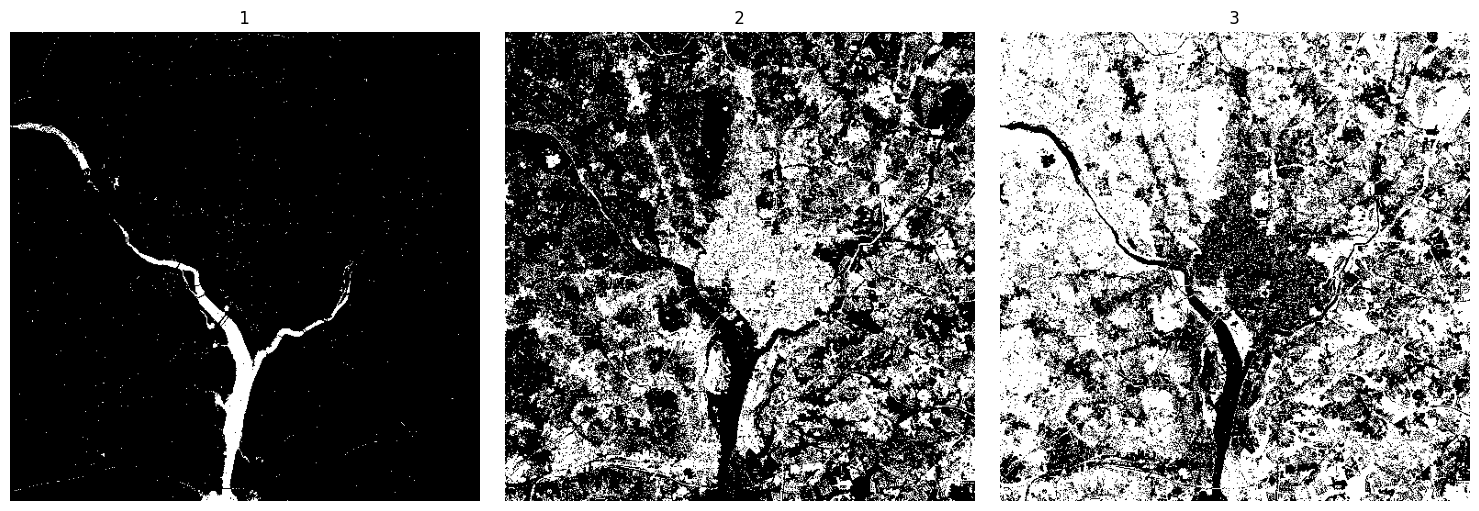

In [ ]:
bayes = bayes(data,mask)
bayes.predict(data)